In [ ]:
pip install -U matplotlib pandas triton

# 向量加法
在本教程中，您将使用 Triton 编写一个简单的向量加法。
在此过程中，您将了解到：
- Triton 的基本编程模型。
- triton.jit 装饰器，用于定义 Triton 内核。
- 根据本机参考实现来验证和基准测试自定​​义操作的最佳实践。

## 计算内核

In [ ]:
# 整体概览
# 这段代码定义了一个名为 add_kernel 的 GPU 核函数。它的功能非常简单：将两个长度为 n_elements 的向量 x 和 y 按元素相加，并将结果存入 output 向量中。这等同于 PyTorch 中的 x + y 操作。
# Triton 的核心思想是让用户可以用类似 Python 的语法编写代码，然后由其 JIT (Just-In-Time) 编译器 自动优化并编译成高效的 GPU 机器码。

# import torch: 导入 PyTorch 库。虽然核函数内部使用 Triton 的语法，但我们通常使用 PyTorch 来管理和分配 GPU 上的张量 (Tensor)。
# import triton: 导入 Triton 库本身。
# import triton.language as tl: 导入 Triton 的核心语言模块，并用 tl作为别名。所有 Triton 核函数内部的操作，如内存读写 (tl.load, tl.store)、程序 ID 获取 (tl.program_id) 等，都来自这个模块。
import torch

import triton
import triton.language as tl

# 定义一个全局变量 DEVICE，用于指定后续操作在哪块 GPU 上执行。
DEVICE = triton.runtime.driver.active.get_active_torch_device()
# 这是一个 JIT 编译器装饰器。它告诉 Triton：“下面的 add_kernel 函数不是一个普通的 Python 函数，请你把它编译成一个高效的 GPU 核函数”。这是使用 Triton 的关键。
@triton.jit
# 这是核函数的定义。它的参数很特别，不是直接传递张量，而是传递一些元数据：
# x_ptr, y_ptr, output_ptr: 这三个是指针，指向输入向量 x、y 和输出向量 output 在 GPU 显存（DRAM）中的起始地址。
# n_elements: 一个整数，代表向量的总长度。
# BLOCK_SIZE: tl.constexpr: 这是一个编译期常量 (constexpr)。它定义了每个并行任务单元（Program）应该处理多少个元素。例如，如果向量总长 1024，BLOCK_SIZE 为 128，那么 Triton 会启动 1024 / 128 = 8 个并行任务。constexpr 意味着这个值在编译时就必须确定，Triton 会利用它来做代码展开等优化，对性能至关重要。
def add_kernel(x_ptr,
               y_ptr,
               output_ptr,
               n_elements,
               BLOCK_SIZE: tl.constexpr, 
               ):
    # GPU 通过启动大量并行任务（在 Triton 中称为 Program）来工作。tl.program_id(axis=0) 用来获取当前这个任务的唯一ID。
    # 打个比方：假设有1000个工人（Programs）去搬砖，这条代码就是让每个工人看一下自己胸前的工牌号（pid），例如 0 号、1 号、2 号…… 这样每个工人就知道自己该负责哪一部分工作。axis=0 表示我们是在一个一维的网格中启动这些任务。
    pid = tl.program_id(axis=0)
    # block_start: 计算当前这个 Program 应该从向量的哪个位置开始处理。例如，如果 BLOCK_SIZE 是 64，那么 0 号 Program 从索引 0 开始，1 号 Program 从索引 64 开始，2 号 Program 从索引 128 开始，以此类推。
    # tl.arange(0, BLOCK_SIZE): 创建一个从 0 到 BLOCK_SIZE - 1 的序列，例如 [0, 1, 2, ..., 63]。
    # offsets: 这是当前 Program 要处理的所有元素的索引集合。以上面的例子继续，1 号 Program 的 offsets 就是 64 + [0, 1, ..., 63]，结果为 [64, 65, ..., 127]。
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    # 这是一个非常重要的安全检查。考虑一种情况：向量总长度 n_elements 是 100，但 BLOCK_SIZE 是 64。
    # 0 号 Program 处理 [0..63]，完全在界内。
    # 1 号 Program 尝试处理 [64..127]，但向量只到索引 99。
    # 这行代码会创建一个掩码 (mask)，offsets 中小于 n_elements 的位置为 True，否则为 False。对于 1 号 Program，它的 mask 就是 [True, True, ..., True (共36个), False, False, ..., False (共28个)]。
    # 这个 mask 能够防止后续的内存读写操作越界，避免程序崩溃。
    mask = offsets < n_elements
    # tl.load: 从 GPU 的全局显存 (DRAM) 中加载数据到更快的片上内存 (SRAM)。
    # x_ptr + offsets: 计算出需要加载的所有元素的内存地址。
    # mask=mask: 应用刚才创建的掩码。只有在 mask 为 True 的位置，tl.load 才会真正执行加载操作。对于 mask 为 False 的位置，则会跳过，从而保证了内存访问的安全性。
    # 这两行代码以向量化的方式，一次性地、安全地将 x 和 y 的一小块数据加载进来。
    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)
    # 在快速的片上内存中，对刚刚加载进来的数据 x 和 y 执行向量加法。这是整个核函数的核心计算步骤。
    output = x + y
    # tl.store: 将计算结果存储回 GPU 的全局显存 (DRAM)。
    # output_ptr + offsets: 计算出需要写入结果的内存地址。
    # mask=mask: 同样使用掩码，确保只在有效的位置写入数据，防止越界污染其他内存区域。
    tl.store(output_ptr + offsets, output, mask=mask)

## `tl.constexpr`

### 一、核心定义：编译期常量

`tl.constexpr` 的全称是 **"Constant Expression"**，即**编译期常量**。

它是一个特殊的标记，用来告诉 Triton 的 JIT (Just-In-Time) 编译器：“这个参数的值，在我**编译这段代码生成 GPU 机器码的时候**，就是一个已知的、固定的常量，而不是一个在运行时（执行时）才会知道的变量。”

### 二、为什么它如此重要？（带来的优化）

当 Triton 编译器知道一个值是常量时，它可以进行一系列大刀阔斧的性能优化，这对于 GPU 编程至关重要：

1.  **循环展开 (Loop Unrolling)**
    这是最常见的优化。如果一个循环的次数是 `constexpr`，编译器会直接把循环体复制展开，变成没有循环的线性代码，从而消除了循环带来的额外开销（如条件判断、计数器递增等）。

    ```python
    # 如果 BLOCK_SIZE 是 constexpr (例如 4)
    for i in tl.static_range(BLOCK_SIZE):
        # ... do something

    # 编译器看到的代码可能是这样的：
    # ... do something with i=0
    # ... do something with i=1
    # ... do something with i=2
    # ... do something with i=3
    ```

2.  **静态分支裁剪 (Static Branching)**
    如果 `if` 语句的判断条件只依赖于 `constexpr`，编译器在编译时就能确定走哪个分支，另一个分支的代码会被完全丢弃，从而减小了最终生成的代码体积和运行时的分支判断开销。

    ```python
    if BLOCK_SIZE > 64:
      # 算法A
    else:
      # 算法B

    # 如果你传入 BLOCK_SIZE=128，那么“算法B”部分的代码将根本不会被编译进最终的核函数。
    ```

3.  **指令和地址计算优化**
    编译器可以预先计算所有与 `constexpr` 相关的表达式，将复杂的计算简化为最终的常数值，减少了 GPU 在运行时需要做的计算量。

4.  **元编程 (Metaprogramming)**
    `tl.constexpr` 是 Triton 实现元编程的基石。它允许你编写一个“模板化”的核函数，然后通过传入不同的 `constexpr` 参数（如块大小、数据类型等），编译生成多个高度特化（specialized）、性能极致的核函数版本。


## `tl.program_id(axis=0)`

它是当前在 GPU 上并行运行的程序实例的唯一 ID

### 一、技术定义
在 GPU 的世界里：
 - 您要执行的任务（例如向量加法）被称为 核函数 (Kernel)。
 - 您一次性派出的成千上万名“工人”，就是 “并行运行的程序实例” (Program Instances)。在 CUDA 中这被称为“线程 (Threads)”，在 Triton 中则抽象为 “程序 (Programs)”。
 - 那个独一无二的“工牌号”，就是我们所说的 “唯一ID (Unique ID)”。
 - 这个 唯一ID 是 GPU 硬件赋予每个并行实例的一个内置变量。它不是一个简单的数字，而是一个坐标，可以是1D、2D或3D，用来标识当前实例在整个并行任务网格（Grid）中的精确位置。

### 二、唯一ID的作用
这个ID是实现并行计算的基石，其主要作用是：
 - 任务划分 (Work Distribution)：这是最核心的作用。每个程序实例通过读取自己的唯一ID，来计算它应该负责处理哪一部分数据。
 - 示例：在向量加法中，ID为 pid 的程序实例负责计算输入数据的第 pid * BLOCK_SIZE 到 (pid + 1) * BLOCK_SIZE - 1 这个区间。
 - 数据访问 (Data Access)：ID决定了程序实例应该从内存的哪个地址读取输入数据，以及将计算结果写回到哪个地址。
 - 控制流 (Control Flow)：在复杂的算法中，可以根据ID的不同来执行不同的逻辑。例如，ID为0的实例可以负责一些初始化的工作。


## `tl.arange`。

### 一、核心功能

`tl.arange` 用于在 Triton 核函数（即 `@triton.jit` 装饰的函数）内部，创建一个**一维的、等差的整数序列**。

它的基本语法是 `tl.arange(start, end)`，会生成一个从 `start` 开始，到 `end - 1` 结束的整数序列。

-----

### 二、与 `numpy.arange` 的关键区别

虽然功能相似，但它们的底层实现和目的完全不同：

| 特性 | `numpy.arange` / `torch.arange` | `tl.arange` (Triton) |
| :--- | :--- | :--- |
| **运行环境** | 在普通的 Python 环境中运行（CPU/GPU） | **只能**在 `@triton.jit` 装饰的函数内部运行 |
| **返回值** | 返回一个存储在内存（DRAM）中的真实数组/张量对象 | 返回一个**概念上的“值向量”**，它存在于 GPU 核心的超高速缓存（SRAM/寄存器）中 |
| **本质** | 一个内存分配和数值计算的函数 | 一个给 JIT 编译器的**指令**，告诉它在生成机器码时，需要一个数值序列 |
| **参数要求** | 参数可以是普通的 Python 变量 | 参数 `start` 和 `end` **必须是编译期常量 (`tl.constexpr`)** |

**关键点**：`tl.arange` 不会去 GPU 的主显存（DRAM）中创建一个完整的数组。它更像是一个生成器，直接在 GPU 核心旁边的快速寄存器里产生一个值的序列，供后续指令立刻使用。这极大地提升了效率，避免了缓慢的显存读写。

-----

### 三、核心用途：实现向量化和地址计算

`tl.arange` 是 Triton 实现 **SPMD (单程序多数据)** 和向量化编程模型的基础。它最核心的用途是高效地计算每个程序实例需要访问的内存地址。

让我们回顾一下您之前看过的 `add_kernel` 代码：

```python
@triton.jit
def add_kernel(..., n_elements, BLOCK_SIZE: tl.constexpr):
    # 1. 获取当前程序实例的ID
    pid = tl.program_id(axis=0)  # 例如，pid = 2

    # 2. 计算这个程序块的起始偏移量（这是一个标量）
    # 例如，BLOCK_SIZE=1024，那么 block_start = 2 * 1024 = 2048
    block_start = pid * BLOCK_SIZE

    # 3. 使用 tl.arange 生成一个块内的相对偏移序列（这是一个向量）
    # 这会生成一个向量：[0, 1, 2, ..., 1023]
    block_offsets = tl.arange(0, BLOCK_SIZE)
    
    # 4. 将标量和向量相加，得到最终的全局内存偏移地址（这也是一个向量）
    # Python的广播机制在此生效
    # offsets = 2048 + [0, 1, 2, ..., 1023]
    # 结果得到一个新的向量：[2048, 2049, 2050, ..., 3071]
    offsets = block_start + block_offsets

    # 5. 使用这个计算出的地址向量去加载数据
    x = tl.load(x_ptr + offsets)
    ...
```

**这个过程清晰地展示了 `tl.arange` 的威力**：

1.  它以一种**向量化**的方式，一次性地为一整个 `BLOCK_SIZE` 的数据点生成了相对地址 `[0, 1, ..., BLOCK_SIZE-1]`。
2.  通过和 `block_start` 这个标量相加（利用了广播机制），高效地计算出了当前程序实例需要操作的所有内存地址。
3.  所有这些计算都在 GPU 的快速寄存器中完成，速度极快。

-----

### 四、与 `tl.static_range` 的区别

您可能还会见到 `tl.static_range`，它和 `tl.arange` 很相似但用途不同：

  * **`tl.arange`**：生成一个**运行时**的值向量，用于计算和掩码（masking）。
  * **`tl.static_range`**：生成一个**编译时**的序列，专门用于可以被编译器**完全展开 (unroll)** 的 `for` 循环。

我们还声明一个辅助函数来（1）分配 z 张量和（2）使用适当的网格/块大小将上述内核入队：

In [ ]:
# 整体概览
# 这是一个 "主机端 (host-side)" 的封装函数。它在 CPU 上运行，其主要职责是作为“指挥官”，
# 负责准备数据、配置参数，并最终启动前面定义的 `add_kernel` GPU 核函数。
# 它处理了所有与 GPU 通信的“杂活”，为用户提供了一个像普通 Python 函数一样简单的调用接口。
def add(x: torch.Tensor, y: torch.Tensor):
    # 预分配输出内存。GPU 核函数通常不会自己创建返回一个新的张量，
    # 而是将计算结果直接写入一个由调用者预先分配好的内存空间中。
    # `torch.empty_like(x)` 会创建一个与输入张量 `x` 具有相同形状、数据类型和设备的空张量，
    # 由于核函数会完全覆盖这片内存，使用 `empty_like` 比 `zeros_like` 更高效。
    output = torch.empty_like(x)
    # 一个重要的断言检查。它确保所有参与运算的张量（输入x, y和输出output）都位于同一个目标GPU设备上。
    # 这是执行GPU计算的必要前提，否则程序会报错。
    assert x.device == DEVICE and y.device == DEVICE and output.device == DEVICE
    # 获取张量中的元素总数 (`numel` 是 "number of elements" 的缩写)。
    # 这个值需要传递给核函数，让其知道需要处理的数据总量有多大，以便正确处理边界情况（例如创建掩码mask）。
    n_elements = output.numel()
    # 定义启动网格 (Launch Grid)。这是GPU编程的核心概念之一，它告诉GPU需要启动多少个并行的核函数实例（即Triton中的Program）。
    # 这个网格的计算方式被定义为一个 lambda 匿名函数，它接收一个包含元参数（meta-parameters）的字典 `meta`。
    # `triton.cdiv(a, b)` 是向上取整除法 (Ceiling Division)，它能确保启动足够多的程序实例来覆盖所有元素，
    # 即使元素总数 `n_elements` 不是 `BLOCK_SIZE` 的整数倍。
    # 最后的逗号 `(..., )` 表示我们定义的是一个一维的启动网格。
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']), )
    # 启动核函数。这是Triton的特殊调用语法。
    # `add_kernel[grid]`: 首先用方括号把我们刚刚定义的 `grid` “附加”到JIT核函数上，
    #   这会返回一个根据 `grid` 配置好的、准备在GPU上执行的可调用对象。
    # `(...)`: 接着，像调用普通函数一样，传入所有核函数需要的参数。
    #   - `x, y, output`: PyTorch张量会被隐式地转换成核函数所期望的指针（ptr）类型。
    #   - `n_elements`: 作为运行时变量传入。
    #   - `BLOCK_SIZE=1024`: 这是一个元参数（meta-parameter），必须以关键字参数的形式传递。
    #     它既被 `grid` 函数用来计算网格大小，也被核函数内部用作 `constexpr` 来进行编译期优化。
    add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=1024)
    # 返回输出张量的句柄。CPU在向GPU发出计算指令后，不会原地等待其完成，而是会立即执行下一行代码。
    # 这被称为“异步执行 (asynchronous execution)”。
    # 因此，这个函数会马上返回 `output` 张量，但此时GPU很可能仍在后台紧张地进行计算。
    # 只有当后续代码需要真正访问 `output` 的数据时（例如打印它或将其复制回CPU），程序才会自动等待GPU计算完成。
    return output

我们现在可以使用上述函数来计算两个 torch.tensor 对象的逐元素和并测试其正确性：

In [ ]:
torch.manual_seed(0)
size = 98432
x = torch.rand(size, device=DEVICE)
y = torch.rand(size, device=DEVICE)
output_torch = x + y
output_triton = add(x, y)
print(output_torch)
print(output_triton)
print(f'The maximum difference between torch and triton is '
      f'{torch.max(torch.abs(output_torch - output_triton))}')

## 基准
现在，我们可以在规模不断增大的向量上对我们的自定义操作进行基准测试，以了解它相对于 PyTorch 的表现。为了简化操作，Triton 提供了一组内置实用程序，使我们能够简明地绘制自定义操作在不同问题规模下的性能图。

In [ ]:
# 整体概览
# 这段代码定义了一个性能基准测试函数，其目的是为了系统性地测量并可视化比较我们自己编写的
# Triton 核函数 (`add` 函数) 与 PyTorch 内置的向量加法 (`x + y`) 之间的性能差异。
# 它使用了 Triton 提供的便捷测试工具 `@triton.testing.perf_report`，这个工具会自动运行
# 不同输入规模下的测试，收集性能数据，并生成一张清晰的性能对比图。

# 这是一个功能强大的装饰器，来自 Triton 的测试套件。它会自动执行基准测试并生成性能报告。
# 它会根据下面的 Benchmark 配置，多次调用被它装饰的 `benchmark` 函数，
# 并将返回的性能数据整理成一张图表。
@triton.testing.perf_report(
    # Benchmark 类用于定义整个基准测试实验的所有参数和配置。
    triton.testing.Benchmark(
        # x_names: 用于图表 x 轴的参数名。这里我们关心的是输入张量的 `size`。
        x_names=['size'],
        # x_vals: x 轴参数 `size` 的一系列取值。这里使用 2 的幂次（从 2^12 到 2^27），
        # 用于测试算法在不同数量级输入下的性能表现。
        x_vals=[2**i for i in range(12, 28, 1)],
        # x_log: 将 x 轴设置为对数坐标，这在观察跨数量级的性能变化时非常有用。
        x_log=True,
        # line_arg: 用于区分图中不同曲线的参数名。我们用它来对比不同的 `provider`（实现方）。
        line_arg='provider',
        # line_vals: `line_arg` 的具体取值。测试将对 'triton' 和 'torch' 分别运行。
        line_vals=['triton', 'torch'],
        # line_names: 图表图例中每条曲线的标签名，与 `line_vals`一一对应。
        line_names=['Triton', 'Torch'],
        # styles: 每条曲线的样式，这里定义了颜色和线型（'-' 代表实线）。
        styles=[('blue', '-'), ('green', '-')],
        # ylabel: 图表 y 轴的标签名。这里我们用内存带宽 (GB/s) 作为性能衡量指标。
        ylabel='GB/s',
        # plot_name: 图表的标题，同时也是保存图表时的文件名。
        plot_name='vector-add-performance',
        # args: 一个字典，用于传递那些不在 `x_names` 和 `line_arg` 中的固定参数。这里为空。
        args={},
    ))
# 这是基准测试的核心执行函数。`@perf_report` 装饰器会使用上面 Benchmark 定义的配置，
# 用不同的 `size` 和 `provider` 组合来多次调用这个函数。
def benchmark(size, provider):
    # 根据传入的 `size`，在指定的 GPU 设备上创建两个随机的32位浮点数张量。
    x = torch.rand(size, device=DEVICE, dtype=torch.float32)
    y = torch.rand(size, device=DEVICE, dtype=torch.float32)
    # 定义分位数。`do_bench` 会多次运行函数以获得稳定的计时，
    # 这些分位数用于报告中位数(0.5)、最好情况(0.2)和最坏情况(0.8)的性能，以消除偶然的性能抖动。
    quantiles = [0.5, 0.2, 0.8]
    # 根据 `provider` 参数的值，选择要进行基准测试的代码。
    if provider == 'torch':
        # 如果是 'torch'，则测试 PyTorch 内置的加法操作。
        # `triton.testing.do_bench` 是一个高精度的计时函数，它会重复运行传入的 lambda 函数并返回耗时。
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)
    if provider == 'triton':
        # 如果是 'triton'，则测试我们自己封装的 `add` 函数。
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add(x, y), quantiles=quantiles)
    # 定义一个 lambda 函数，用于将测得的耗时（毫秒, ms）转换成内存带宽（GB/s）。
    # 计算公式：(总数据量 / 总时间)。
    # 总数据量 = 3 * 元素数量 * 每个元素的大小。这里的 3 是因为操作涉及2次读取(x, y)和1次写入(output)。
    # 总时间 = 毫秒 * 1e-3 (转换为秒)。
    # 字节到GB的转换因子是 1e-9。
    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    # 返回中位数、最差情况（对应最长耗时 min_ms）和最好情况（对应最短耗时 max_ms）下的带宽。
    # 装饰器会利用这些返回值来绘制带有误差区间的性能曲线。
    return gbps(ms), gbps(max_ms), gbps(min_ms)

现在我们可以运行上面装饰好的函数了。传入 `print_data=True` 可以查看性能数据， 传入 `show_plots=True` 可以绘制图表，或者 `save_path='/path/to/results/'` 将它们与原始 CSV 数据一起保存到磁盘：

In [ ]:
benchmark.run(print_data=True, show_plots=True)

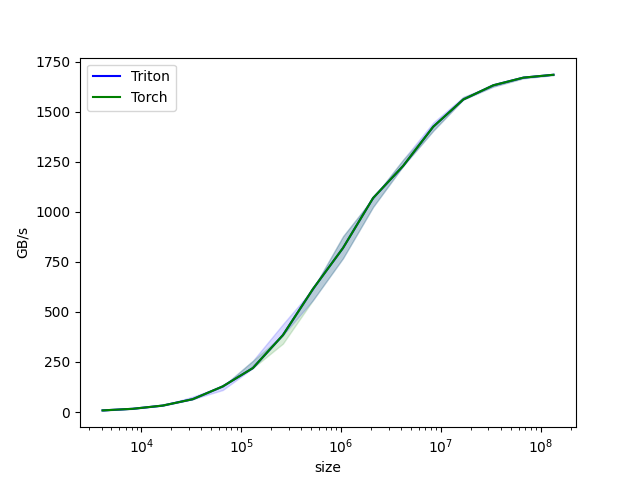